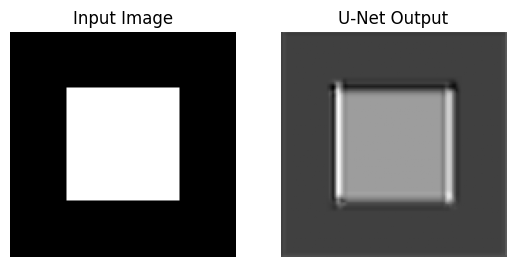

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

#Dummy Image
# 128x128 mit zwei Bereiche
image = np.zeros((128, 128), dtype=np.float32)
image[32:96, 32:96] = 1.0  # quadratisches Objekt

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

#Einfacher Mini U-Net
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(1, 8, 3, padding=1)
        self.enc2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = nn.Conv2d(16, 8, 3, padding=1)
        self.out = nn.Conv2d(8, 1, 1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(self.pool(x1)))
        x3 = F.relu(self.dec1(self.up(x2)))
        x4 = torch.sigmoid(self.out(x3))
        return x4

# Modell und Input vorbereiten
model = MiniUNet()
model.eval()  # eval mode, keine Gradienten nötig

input_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # [B, C, H, W]
with torch.no_grad():
    output = model(input_tensor).squeeze().numpy()

#Ergebnis anzeigen
plt.subplot(1, 2, 2)
plt.title("U-Net Output")
plt.imshow(output, cmap='gray')
plt.axis('off')

plt.show()


CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt

# für Notebook: Plots inline
%matplotlib inline

# ----------------------------
# 1. Daten vorbereiten (Mini-Subset + Augmentation)
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_indices = list(range(10000))  # kleines Subset für schnelle Tests
subset = Subset(dataset, subset_indices)

train_dataset, val_dataset = random_split(subset, [8000,2000])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ----------------------------
# 2. Mini-CNN mit BatchNorm + Dropout
# ----------------------------
class MiniCNN(nn.Module):
    def __init__(self):
        super(MiniCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.dropout = nn.Dropout(0.2)  # Dropout vor FC Layer
        self.fc2 = nn.Linear(64, 10)  # CIFAR10: 10 Klassen

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 64*4*4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------------
# 3. Training Setup
# ----------------------------
device = torch.device("cpu")
model = MiniCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # L2 Regularization   

num_epochs = 10
train_losses, val_losses = [], []

# ----------------------------
# 4. Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# ----------------------------
# 5. Loss Plot
# ----------------------------
plt.plot(range(1,num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1,num_epochs+1), val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



# Validation
model.eval()
val_loss = 0.0
correct_total = 0
total_samples = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        val_loss += loss.item()
        
        # Accuracy berechnen
        preds = torch.argmax(outputs, dim=1)
        correct_total += (preds == labels.to(device)).sum().item()
        total_samples += labels.size(0)

val_accuracy = correct_total / total_samples
print(f"Validation Accuracy: {val_accuracy:.2%}")


Epoch 1/10, Train Loss: 1.8781, Val Loss: 1.5627
Epoch 2/10, Train Loss: 1.5468, Val Loss: 1.4609
Epoch 3/10, Train Loss: 1.4177, Val Loss: 1.4915
Epoch 4/10, Train Loss: 1.3389, Val Loss: 1.3034
Epoch 5/10, Train Loss: 1.2758, Val Loss: 1.2624
Epoch 6/10, Train Loss: 1.2229, Val Loss: 1.3973
Epoch 7/10, Train Loss: 1.1769, Val Loss: 1.2100
